### PAR-2(GCN4) in par-3 mutant cells

Context:
- PAR-2(GCN4) displays strong localisation to internal membranes and reduced plasma membrane association
- Models predict that this should be an out-of-equilibrium phenomenon, so putting cells in a state closer to equilibrium should reduce this apparent loss of membrane specificity
- We use par-3(it71), in which the plasma membrane is available to PAR-2 for a longer time period before imaging, to push cells closer to equilibrium

Results:
- Internal membrane association of PAR-2(GCN4) is reduced in par-3(it71) cells, and plasma membrane association is restored - in line with predictions

Dependencies:
- Relies on quantification data generated by _Run/par2_nebd_quantify.ipynb_

In [1]:
import os

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

from src import (
    add_stats_table_row,
    bootstrap_effect_size_pd,
    dataplot,
    lighten,
    load_image,
    raw_data_path,
    rotated_embryo,
)

%matplotlib inline

mpl.rcParams["figure.dpi"] = 150

if not os.path.exists("Figs"):
    os.mkdir("Figs")

### Image paths

In [2]:
wt_pol_path = raw_data_path + "/Imaging/par2_nebd/210428_lp637_tom4,15,60/16"
wt_uni_path = raw_data_path + "/Imaging/par2_nebd/211113_nwg201_wt_tom4,15,60/00"
gcn4_pol_path = raw_data_path + "/Imaging/par2_nebd/210722_nwg376_tom4,15,60/03"
gcn4_uni_path = raw_data_path + "/Imaging/par2_nebd/211209_nwg437_tom4,15,60/00"

### Zoom

10740.014217473643
7443.275744373258


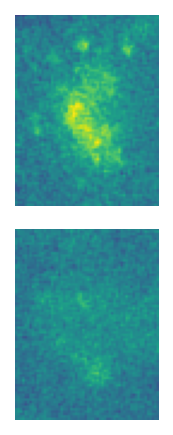

In [3]:
ybox = [60, 120]
xbox = [50, 130]


def panel_internal(path, ax):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    rotated_filter = gaussian_filter(rotated, 0.5)
    rotated_box = rotated_filter[xbox[0] : xbox[1], ybox[0] : ybox[1]]
    print(np.percentile(rotated_box, 99.9))
    ax.imshow(rotated_box, cmap="viridis", vmin=0, vmax=11109.124382104814)
    ax.axis("off")


if raw_data_path:
    fig, ax = plt.subplots(2, 1)
    panel_internal(gcn4_pol_path, ax[0])
    panel_internal(gcn4_uni_path, ax[1])
    fig.set_size_inches(2, 3)
    fig.tight_layout()
    fig.savefig("Figs/par3mut_imgs_zoom.png", dpi=600, transparent=True)

### Images with boxes

22697.921565679884
12015.175933646213
15241.352494142408
12861.076669123322


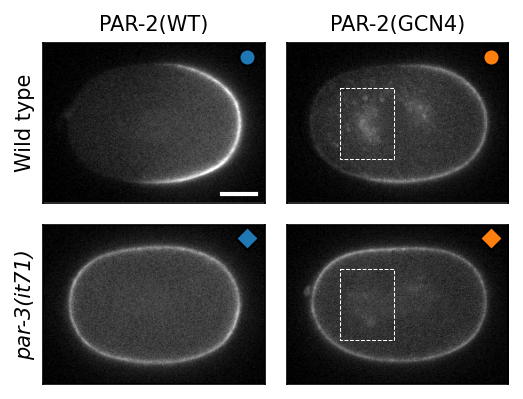

In [4]:
def panel(path, ax, scale_bar=False):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    print(np.percentile(rotated, 99.9))
    ax.imshow(rotated, cmap="gray", vmin=0, vmax=22546.215885725764)
    ax.set_xticks([])
    ax.set_yticks([])

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )


if raw_data_path:
    fig, ax = plt.subplots(2, 2)
    panel(wt_pol_path, ax[0][0], scale_bar=True)
    panel(gcn4_pol_path, ax[0][1])
    panel(wt_uni_path, ax[1][0])
    panel(gcn4_uni_path, ax[1][1])

    ax[0][0].set_title("PAR-2(WT)", fontsize=10)
    ax[0][1].set_title("PAR-2(GCN4)", fontsize=10)
    ax[0][0].set_ylabel("Wild type", fontsize=10)
    ax[1][0].set_ylabel("par-3(it71)", fontsize=10, style="italic")

    recta = patches.Rectangle(
        (ybox[0], xbox[0]),
        ybox[1] - ybox[0],
        xbox[1] - xbox[0],
        linewidth=0.5,
        edgecolor="w",
        facecolor="none",
        linestyle="--",
    )
    ax[0][1].add_patch(recta)

    rectb = patches.Rectangle(
        (ybox[0], xbox[0]),
        ybox[1] - ybox[0],
        xbox[1] - xbox[0],
        linewidth=0.5,
        edgecolor="w",
        facecolor="none",
        linestyle="--",
    )
    ax[1][1].add_patch(rectb)

    ax[0][0].scatter(230, 15, c="tab:blue", s=60, edgecolors="k")
    ax[0][1].scatter(230, 15, c="tab:orange", s=60, edgecolors="k")
    ax[1][0].scatter(230, 15, c="tab:blue", s=60, edgecolors="k", marker="D")
    ax[1][1].scatter(230, 15, c="tab:orange", s=60, edgecolors="k", marker="D")

    fig.set_size_inches(4, 3)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.savefig("Figs/par3mut_imgs.png", dpi=600, transparent=True)

### Plot: Fraction of protein on PM

In [5]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df = df[df.RNAi == "wt"]
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Calculate summary data
df_quantification_grouped = df_quantification.groupby("EmbryoID")
_dfs = []
for i, r in df_quantification_grouped:
    cyt = np.mean(r["Cytoplasmic signal"])
    mem_tot = np.mean(r["Membrane signal"])
    mem_frac = mem_tot / ((cyt / 0.174) + mem_tot)

    p = {"EmbryoID": i, "Cyt": cyt, "Mem_tot": mem_tot, "Mem_frac": mem_frac}
    _dfs.append(pd.DataFrame(p, index=[i]))
df_summary = pd.concat(_dfs)
df = pd.merge(df, df_summary, on="EmbryoID")

# Filter
df = df[df.Line.isin(["lp637", "nwg201", "nwg376", "nwg437"])]

# Add uniform vs polarised column
unipol = ["Pol" if x in ["lp637", "nwg376"] else "Uni" for x in df.Line]
df["UniPol"] = unipol

# Add genotype column
genotype = ["WT" if x in ["lp637", "nwg201"] else "GCN4" for x in df.Line]
df["Genotype"] = genotype

/usr/local/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


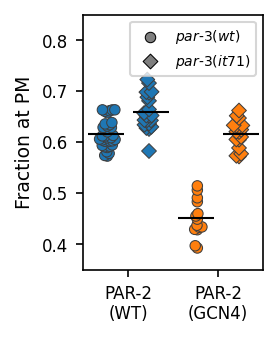

In [6]:
_df = df[df.RNAi == "wt"]

# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Color palletes
palette1 = {"WT": "tab:blue", "GCN4": "tab:orange"}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ["WT", "GCN4"]

# Plot polarised data
dataplot(
    data=_df[_df.UniPol == "Pol"],
    x="Genotype",
    y="Mem_frac",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    linewidth=0.5,
    offset=-0.25,
    marker="o",
)

# Plot uniform data
dataplot(
    data=_df[_df.UniPol == "Uni"],
    x="Genotype",
    y="Mem_frac",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(10),
    linewidth=0.5,
    offset=0.25,
    marker="D",
)

# Legend
dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors="k", color="tab:gray", s=25)
dot2 = ax.scatter(
    x=[], y=[], linewidth=0.5, edgecolors="k", color="tab:gray", s=25, marker="D"
)
ax.legend(
    [dot1, dot2],
    [r"$par$" + "-" + r"$3(wt)$", r"$par$" + "-" + r"$3(it71)$"],
    fontsize=6.7,
    loc="upper right",
)

# Finalise figure
ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(GCN4)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0.35, 0.85)
ax.set_ylabel("Fraction at PM", fontsize=9)
fig.set_size_inches(2, 2.5)
fig.subplots_adjust(left=0.3, bottom=0.2)
fig.savefig("Figs/par3mut_frac.png", dpi=600, transparent=True)

In [7]:
# Effect of GCN4 in polarised conditions
es = bootstrap_effect_size_pd(
    data=_df[_df.UniPol == "Pol"], x="Genotype", y="Mem_frac", a="WT", b="GCN4"
)
add_stats_table_row(
    figure="5",
    panel="F",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(GCN4); par-3(wt)",
    measure="Fraction at PM",
    comparisons=es,
    key="aawszPTkQW",
)

# Effect of GCN4 in uniform conditions
es = bootstrap_effect_size_pd(
    data=_df[_df.UniPol == "Uni"], x="Genotype", y="Mem_frac", a="WT", b="GCN4"
)
add_stats_table_row(
    figure="5",
    panel="F",
    sample_a="PAR-2(WT); par-3(it71)",
    sample_b="PAR-2(GCN4); par-3(it71)",
    measure="Fraction at PM",
    comparisons=es,
    key="OBtlrdzVwU",
)

# Effect of uniform vs polarised in WT conditions
es = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "WT"], x="UniPol", y="Mem_frac", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="5",
    panel="F",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(WT); par-3(it71)",
    measure="Fraction at PM",
    comparisons=es,
    key="C4TqtEDU45",
)

# Effect of uniform vs polarised in GCN4 conditions
es = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "GCN4"], x="UniPol", y="Mem_frac", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="5",
    panel="F",
    sample_a="PAR-2(GCN4); par-3(wt)",
    sample_b="PAR-2(GCN4); par-3(it71)",
    measure="Fraction at PM",
    comparisons=es,
    key="4wa8Jog9aS",
)